## Maximal Update Parameterization

In this problem, we will examine the training of a simple MLP with hidden layers of varying widths. We will then investigate the maximal update parameterization (muP) which will allow us to use a single global learning rate to jointly train layers of any width.

Note: This homework question is new this year and it is messier than usual. We felt it was worth it to get it out so you can play with these new techniques. If you're feeling stuck, don't hesistate to ask questions on Ed.


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

%matplotlib inline

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes = [8, 16, 32, 64, 128], num_classes=10):
        super(MLP, self).__init__()
        all_hidden_sizes = [input_size] + hidden_sizes + [num_classes]
        self.layers = nn.ModuleList()
        for i in range(len(all_hidden_sizes)-1):
            self.layers.append(nn.Linear(all_hidden_sizes[i], all_hidden_sizes[i+1]))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        activations = []
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 28*28)
        for layer in self.layers[:-1]:
            x = self.sigmoid(layer(x))
            activations.append(x)
        x = self.layers[-1](x)
        activations = activations[1:]
        return x, [a.detach() for a in activations]

# Load MNIST data
(train_images, train_labels), (valid_images, valid_labels) = mnist.load_data()

# Normalize pixel values to [0, 1]
train_images = train_images.astype(np.float32) / 255.0
valid_images = valid_images.astype(np.float32) / 255.0

# Convert to PyTorch tensors
train_images = torch.from_numpy(train_images)
train_labels = torch.from_numpy(train_labels).long()
valid_images = torch.from_numpy(valid_images)
valid_labels = torch.from_numpy(valid_labels).long()

def rms(x, dim):
    return torch.sqrt(torch.mean(x**2, dim=dim))


In [18]:
from torch.optim.optimizer import Optimizer
from typing import Any
class SimpleAdam(Optimizer):
    def __init__(
        self,
        params: Any,
        lr: float = 1e-1,
        b1: float = 0.9,
        b2: float = 0.999,
    ):
        defaults = dict(lr=lr, b1=b1, b2=b2,)
        super(SimpleAdam, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)
                    state['variance'] = torch.zeros_like(p)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1-group["b1"])
                v = state['variance']
                v.lerp_(grad**2, 1-group["b2"])

                m_hat = m / (1 - group["b1"]**state['step'])
                v_hat = v / (1 - group["b2"]**state['step'])
                u = m_hat / (torch.sqrt(v_hat) + 1e-16)

                p.add_(u, alpha=-group['lr'])
        return None

[torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 256]), torch.Size([64, 256]), torch.Size([64, 1024])]


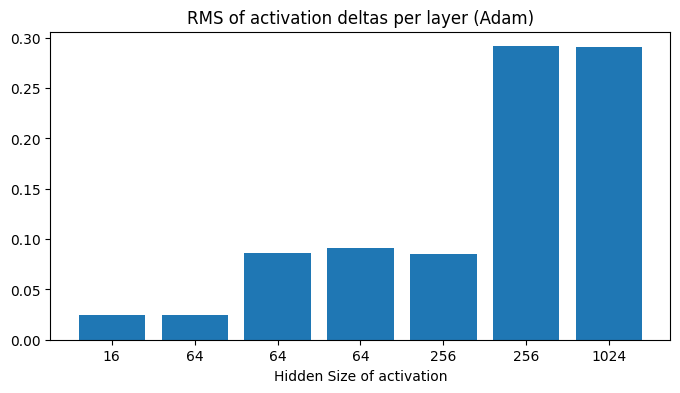

In [19]:
batch_idx = np.random.randint(0, len(train_images), size=64)
def train_one_step(mlp=MLP, hiddens=[8, 16, 64, 64, 64, 256, 256, 1024], optimizer=SimpleAdam, label="Adam", lr=0.01):
    model = mlp(hidden_sizes=hiddens).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=lr)

    prev_activations = None
    for i in range(2):
        images_batch = train_images[batch_idx]
        labels_batch = train_labels[batch_idx]
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs, activations = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        if i > 0:
            print([a.shape for a in activations])
            activation_deltas = [a - pa for a, pa in zip(activations, prev_activations)]
            activation_deltas_rms = [torch.mean(rms(a, dim=-1)) for a in activation_deltas]
        prev_activations = activations

    # plot deltas
    deltas = np.array(activation_deltas_rms)
    fig, axs = plt.subplots(1, figsize=(8, 4))
    axs.set_title(f'RMS of activation deltas per layer ({label})')
    axs.set_xlabel('Hidden Size of activation')
    axs.bar(np.arange(deltas.shape[0]), deltas)
    axs.set_xticks(np.arange(deltas.shape[0]))
    axs.set_xticklabels(hiddens[1:])
    plt.show()
train_one_step(optimizer=SimpleAdam)

## a. Examining the norms of a heterogenous MLP.

Run the above cell, which trains a neural network for a single gradient step, then examines the effect of that step on the resulting activations. What are the dimensions of each layer in the neural network?

*Answer:* Each layer has din of 16, 64, 64, 64, 256, 256, and dout of
64, 64, 256, 256, 1024

How does the dimensionality of the layer affect the RMS norm of the activation deltas?

*Answer:* The RMS norm is only affected by the din. As din increases, the
RMS norm increases accordingly. For example, if din varies from 16 to 32,
RMS norm also changes to 2*RMS.

Change the widths of some of your neural network layers, and recreate the plot -- did the RMS values change as expected?

*Answer:* Yes. See the cell below.


[torch.Size([64, 16]), torch.Size([64, 32]), torch.Size([64, 32]), torch.Size([64, 64]), torch.Size([64, 128]), torch.Size([64, 128]), torch.Size([64, 256]), torch.Size([64, 256]), torch.Size([64, 1024])]


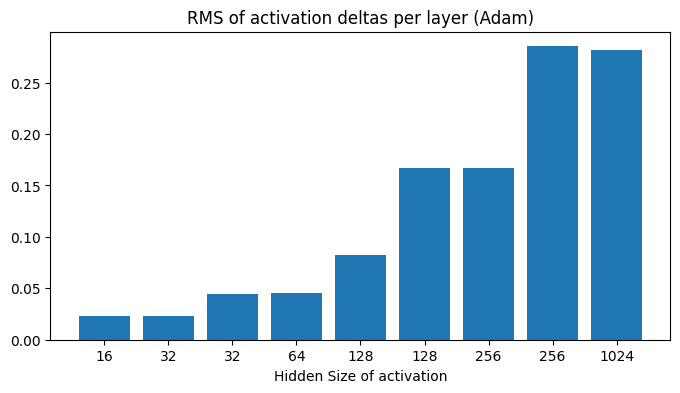

In [20]:
# TODO: Call some plotting code here.
def train_one_step_modified(mlp=MLP, hiddens=[8, 16, 32, 32, 64, 128, 128, 256, 256, 1024], optimizer=SimpleAdam, label="Adam", lr=0.01):
    model = mlp(hidden_sizes=hiddens).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=lr)

    prev_activations = None
    for i in range(2):
        images_batch = train_images[batch_idx]
        labels_batch = train_labels[batch_idx]
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs, activations = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        if i > 0:
            print([a.shape for a in activations])
            activation_deltas = [a - pa for a, pa in zip(activations, prev_activations)]
            activation_deltas_rms = [torch.mean(rms(a, dim=-1)) for a in activation_deltas]
        prev_activations = activations

    # plot deltas
    deltas = np.array(activation_deltas_rms)
    fig, axs = plt.subplots(1, figsize=(8, 4))
    axs.set_title(f'RMS of activation deltas per layer ({label})')
    axs.set_xlabel('Hidden Size of activation')
    axs.bar(np.arange(deltas.shape[0]), deltas)
    axs.set_xticks(np.arange(deltas.shape[0]))
    axs.set_xticklabels(hiddens[1:])
    plt.show()
train_one_step_modified(optimizer=SimpleAdam)

## b. Examining the norms of the updates to the weights.

In the provided code above, we plotted the change in norms of the *activation vectors*. Now, you will examine the change in the weights themselves. Create a version of the above function that runs a single gradient step, then for each dense layer plot:
- The *Frobenius* norm of the update.
- The *spectral* norm of the update.
- The *RMS-RMS induced norm* of the update.

Which one of these norms correlates the most with the RMS norms of the activations?

*Answer:* The RMS->RMS norm.

You should calculate your updates as `new_dense_parameter - old_dense_parameter`.

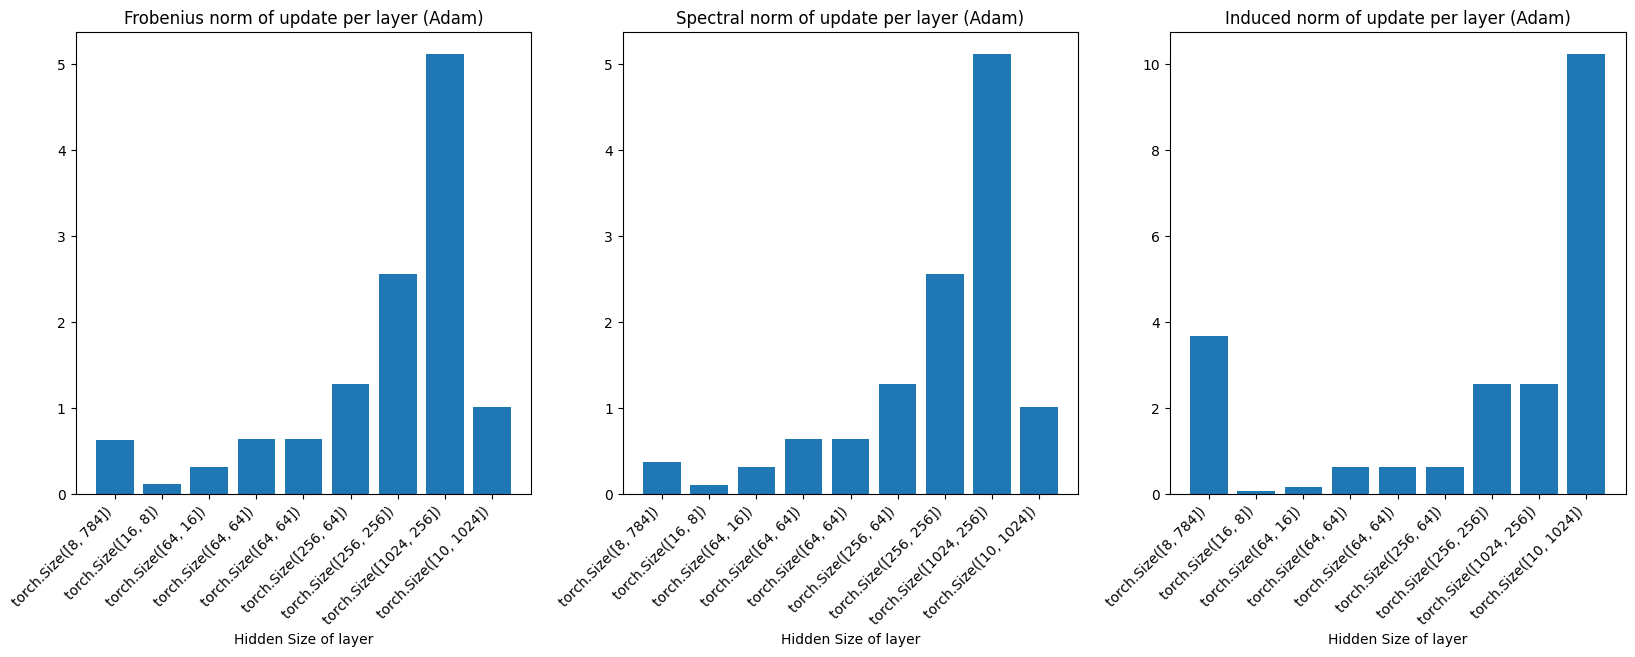

In [33]:
### Solution
batch_idx = np.random.randint(0, len(train_images), size=64)
def train_one_step_matrices(mlp=MLP, hiddens=[8, 16, 64, 64, 64, 256, 256, 1024], optimizer=SimpleAdam, label="Adam", lr=0.01):
    model = mlp(hidden_sizes=hiddens).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=lr)

    old_params = [p.detach().clone() for p in model.parameters()]

    for i in range(1):
        images_batch = train_images[batch_idx]
        labels_batch = train_labels[batch_idx]
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs, activations = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

    new_params = [p.detach().clone() for p in model.parameters()]
    delta_params = [new_p - old_p for new_p, old_p in zip(new_params, old_params)]

    frob_norms = []
    spectral_norms = []
    induced_norms = []
    p_shapes = []

    for p in delta_params:
        if len(p.shape) == 2:
            frob_norms.append(torch.linalg.norm(p, ord='fro').item())
            spectral_norms.append(torch.linalg.norm(p, ord=2).item())
            induced_norms.append(torch.linalg.norm(p, ord=2).item()*np.sqrt(p.shape[1]/p.shape[0]))
            p_shapes.append(p.shape)
        #     print("p.shape equals 2:", p.shape)
        #     print("old_para_shape", len(old_params))
        #     print("new_para_shape", len(new_params))


    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    axs[0].set_title(f'Frobenius norm of update per layer ({label})')
    axs[0].set_xlabel('Hidden Size of layer')
    axs[0].bar(np.arange(len(frob_norms)), frob_norms)
    axs[0].set_xticks(np.arange(len(frob_norms)), p_shapes, rotation=45, ha='right')

    axs[1].set_title(f'Spectral norm of update per layer ({label})')
    axs[1].set_xlabel('Hidden Size of layer')
    axs[1].bar(np.arange(len(spectral_norms)), spectral_norms)
    axs[1].set_xticks(np.arange(len(spectral_norms)), p_shapes, rotation=45, ha='right')

    axs[2].set_title(f'Induced norm of update per layer ({label})')
    axs[2].set_xlabel('Hidden Size of layer')
    axs[2].bar(np.arange(len(induced_norms)), induced_norms)
    axs[2].set_xticks(np.arange(len(induced_norms)), p_shapes, rotation=45, ha='right')
    plt.show()
train_one_step_matrices(optimizer=SimpleAdam)

## c. Implementing muP

We will now implement muP scaling. Modify the starter code below to set a per-layer learning rate such that the resulting RMS activation-deltas are uniform scale, regardless of the layer widths. Plot the resulting activation-deltas on at least two sets of widths.

Note: Even with the correct scaling, the first 2-3 activation-deltas may have a lower norm than the rest. Can you think of a reason why this might be the case?

*Answer*: Probably because the first layers are relatd to the random initialization, it takes some layers for the activations to converge.

[torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 256]), torch.Size([64, 256]), torch.Size([64, 1024])]


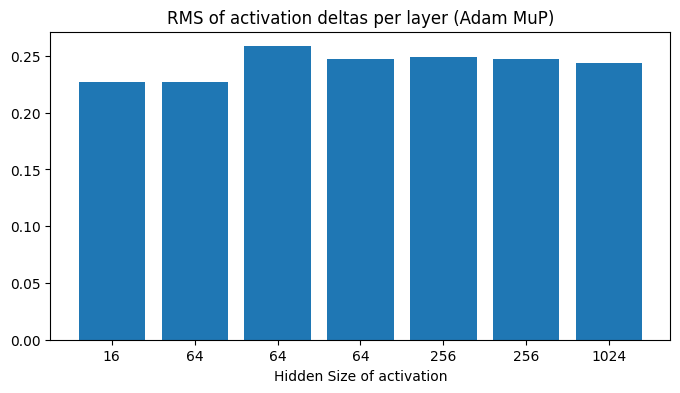

[torch.Size([64, 16]), torch.Size([64, 32]), torch.Size([64, 64]), torch.Size([64, 128]), torch.Size([64, 256]), torch.Size([64, 512]), torch.Size([64, 1024])]


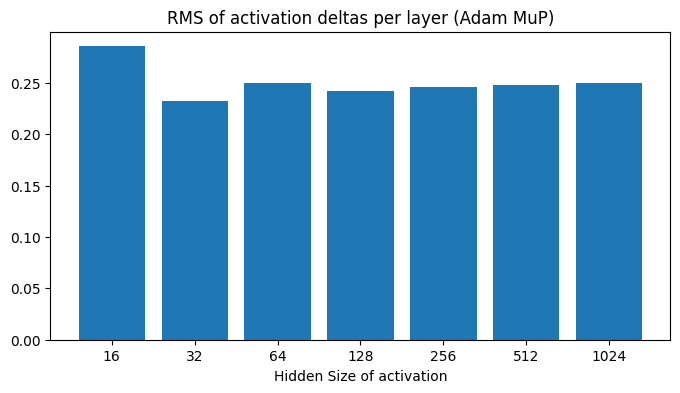

In [50]:
from torch.optim.optimizer import Optimizer
from typing import Any
class SimpleAdamMuP(Optimizer):
    def __init__(
        self,
        params: Any,
        lr: float = 1e-1,
        b1: float = 0.9,
        b2: float = 0.999,
    ):
        defaults = dict(lr=lr, b1=b1, b2=b2,)
        super(SimpleAdamMuP, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)
                    state['variance'] = torch.zeros_like(p)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1-group["b1"])
                v = state['variance']
                v.lerp_(grad**2, 1-group["b2"])

                m_hat = m / (1 - group["b1"]**state['step'])
                v_hat = v / (1 - group["b2"]**state['step'])
                u = m_hat / (torch.sqrt(v_hat) + 1e-16)

                # print("u_shape", u.shape)
                # print("p_shape", p.shape)

                ############################
                ### Todo: Adjust the per-layer learning rate scaling factor so per-layer RMS activation deltas are constant.
                ### Hint for part e: The following tricks will help you retain performance when using muP scaling.
                ###  - Treat biases as a hidden layer with size (d_out, 1). You will need to use a fudge-factor of around 0.01 -- we want to keep the change in bias terms low.
                ###  - For the input layer, a fudge factor of 10 appears to help.
                ###  - For the output layer, we find it is best to ignore the muP scaling, and instead use a fixed learning rate (e.g. 0.003).
                ############################
                lr = group['lr']
                if len(u.shape) == 2:
                  if u.shape[1] == 784:
                    lr *= 10 # fudge factor 10 for input layer
                  elif u.shape[1] == 1024:
                    lr *= 0.003 # fudge factor 0.003 for output layer
                  else: lr /= u.shape[1] # divided by din
                else:
                  lr *= 0.01 # fudge factor 0.01 for bias

                # if len(u.shape) == 2:
                #   lr /= u.shape[1] # divided by din
                # else:
                #   lr *= 0.01 # fudge factor 0.01 for bias
                ############################
                ############################

                p.add_(u, alpha=-lr)
        return None
train_one_step(optimizer=SimpleAdamMuP, lr=2, label="Adam MuP", hiddens=[8, 16, 64, 64, 64, 256, 256, 1024])
train_one_step(optimizer=SimpleAdamMuP, lr=2, label="Adam MuP", hiddens=[8, 16, 32, 64, 128, 256, 512, 1024])

## d. Per-Weight Multipliers

An alternative way to implement muP is to adjust the *network graph* itself, rather than the optimizer. Implement this below, and recreate the above uniformly-scaled graph when using the *Adam* (not muP) optimizer. We have disabled biases to simplify the problem.

Why is multiplying the output of a layer by a constant the same as adjusting the learning-rate of that layer (when using Adam or SignGD)?

*Answer:* That's because adjusting the activations also modifies the gradient in the same way. If we multiply it by a factor, it's equal to adjusting the
learning rate.


[torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 256]), torch.Size([64, 256]), torch.Size([64, 1024])]


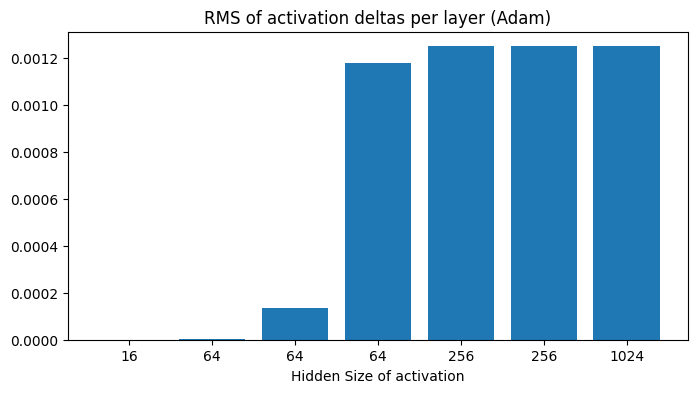

In [53]:
class ScaledMLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes = [8, 16, 32, 64, 128], num_classes=10):
        super(ScaledMLP, self).__init__()
        all_hidden_sizes = [input_size] + hidden_sizes + [num_classes]
        self.layers = nn.ModuleList()
        for i in range(len(all_hidden_sizes)-1):
            self.layers.append(nn.Linear(all_hidden_sizes[i], all_hidden_sizes[i+1], bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        activations = []
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 28*28)
        for layer in self.layers[:-1]:
            x = layer(x)
            x *= 1/layer.weight.shape[1] # Scaling factor
            x = self.sigmoid(x)
            activations.append(x)
        x = self.layers[-1](x)
        activations = activations[1:]
        return x, [a.detach() for a in activations]


train_one_step(mlp=ScaledMLP, optimizer=SimpleAdam)

## e. Hyperparameter Transfer

Run the following code, which will perform a sweep over learning rates for 3-layer MLPs of increasing width using Adam. How does the optimal learning rate change as the network increases in size?

*Answer:* The optimal learning rate shift left as the size of network increases.

In the second cell, we will instead use the muP optimizer you implemented. How does the optimal learning rate work now? You should aim to show that there is a single global learning rate that works on a majority of widths. The 256-width network should achieve a loss of 0.5, comparable to Adam.

*Answer:* The optimal learning rate is more stable. No matter what size the network has, the optimal lr stays almost the same.


In [54]:
valid_idx = np.random.randint(0, len(train_images), size=64)
valid_images = train_images[valid_idx]
valid_labels = train_labels[valid_idx]
valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)


def train_with_lr(hiddens=[64, 64, 64], optimizer=SimpleAdam, lr=0.01):
    torch.manual_seed(4)
    np.random.seed(4)
    model = MLP(hidden_sizes=hiddens).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=lr)
    losses = []

    for i in range(100):
        batch_idx = np.random.randint(0, len(train_images), size=64)

        images_batch = train_images[batch_idx]
        labels_batch = train_labels[batch_idx]
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs, _ = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            outputs_valid, _ = model(valid_images)
            valid_losses = criterion(outputs_valid, valid_labels)
            losses.append(valid_losses.item())

    return np.mean(np.array(losses)[-5:])



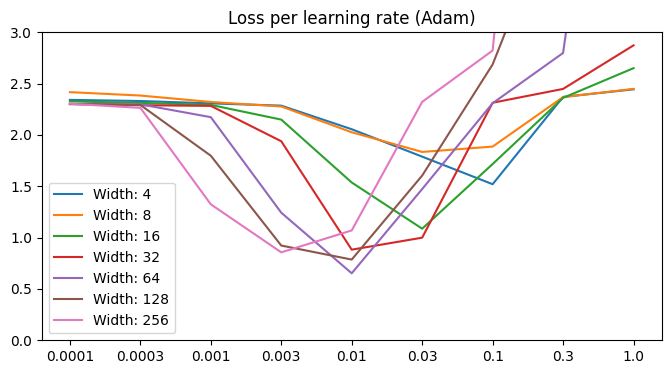

In [55]:
all_widths = [4, 8, 16, 32, 64, 128, 256]
all_lrs = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
adam_results = np.zeros((len(all_widths), len(all_lrs)))
for wi, width in enumerate(all_widths):
    for lri, lr in enumerate(all_lrs):
        loss = train_with_lr(hiddens=[width, width, width], lr=lr)
        adam_results[wi, lri] = loss

fig, axs = plt.subplots(1, figsize=(8, 4))
axs.set_title(f'Loss per learning rate (Adam)')
for wi, width in enumerate(all_widths):
    axs.plot(np.arange(len(all_lrs)), adam_results[wi], label=f'Width: {width}')
axs.set_xticks(np.arange(len(all_lrs)))
axs.set_xticklabels(all_lrs)
axs.set_ylim(bottom=0, top=3)
axs.legend()
fig.show()

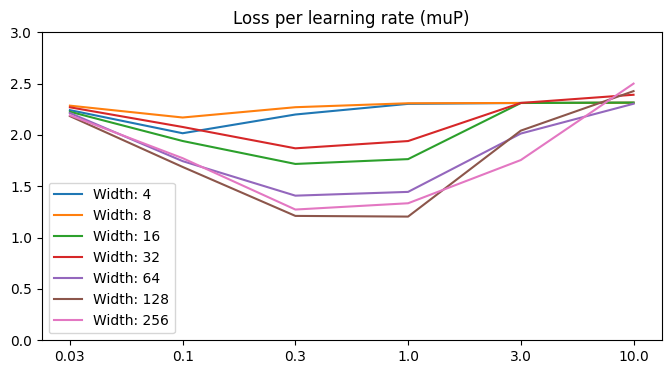

In [56]:
all_widths = [4, 8, 16, 32, 64, 128, 256]
all_lrs = [0.03, 0.1, 0.3, 1.0, 3.0, 10.0]
mup_results = np.zeros((len(all_widths), len(all_lrs)))
for wi, width in enumerate(all_widths):
    for lri, lr in enumerate(all_lrs):
        loss = train_with_lr(hiddens=[width, width, width], lr=lr, optimizer=SimpleAdamMuP)
        mup_results[wi, lri] = loss

fig, axs = plt.subplots(1, figsize=(8, 4))
axs.set_title(f'Loss per learning rate (muP)')
for wi, width in enumerate(all_widths):
    axs.plot(np.arange(len(all_lrs)), mup_results[wi], label=f'Width: {width}')
axs.set_xticks(np.arange(len(all_lrs)))
axs.set_xticklabels(all_lrs)
axs.set_ylim(bottom=0, top=3)
axs.legend()
fig.show()

## e. Shampoo and Orthogonalization

In lecture, we discussed a simplified version of the Shampoo update, which can be viewed as *orthogonalizing* the update to a dense layer. In the following code block, implement this simplified Shampoo update:

$$
momentum \rightarrow U \Sigma V^T. \qquad update = UV^T.
$$

Feel free to use linear algebra functions such as `torch.linalg.svd`.

In [57]:
from torch.optim.optimizer import Optimizer
from typing import Any
class SimpleShampoo(Optimizer):
    def __init__(
        self,
        params: Any,
        lr: float = 1e-1,
        b1: float = 0.9,
    ):
        defaults = dict(lr=lr, b1=b1)
        super(SimpleShampoo, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1-group["b1"])

                ############ TODO
                if len(m.shape) == 1:
                    # bias terms: just use momentum as update
                    u = m
                else:
                    # weight matrix: do SVD
                    U, S, Vh = torch.linalg.svd(m, full_matrices=False)
                    u = U @ Vh  # drop singular values, keep orthogonal factors
                #############
                p.add_(u, alpha=-group['lr'])
        return None

Now, we will examine the relationship between the Frobenius norm and the Spectral norm for Adam vs. Shampoo. Plot these norms using your code from part c. What relationship do you see? Can you come up for a reason why this makes sense?

*Answer:*

Bonus: How should we scale the Shampoo update so the *induced RMS-RMS norm* is equal? Implement this change.

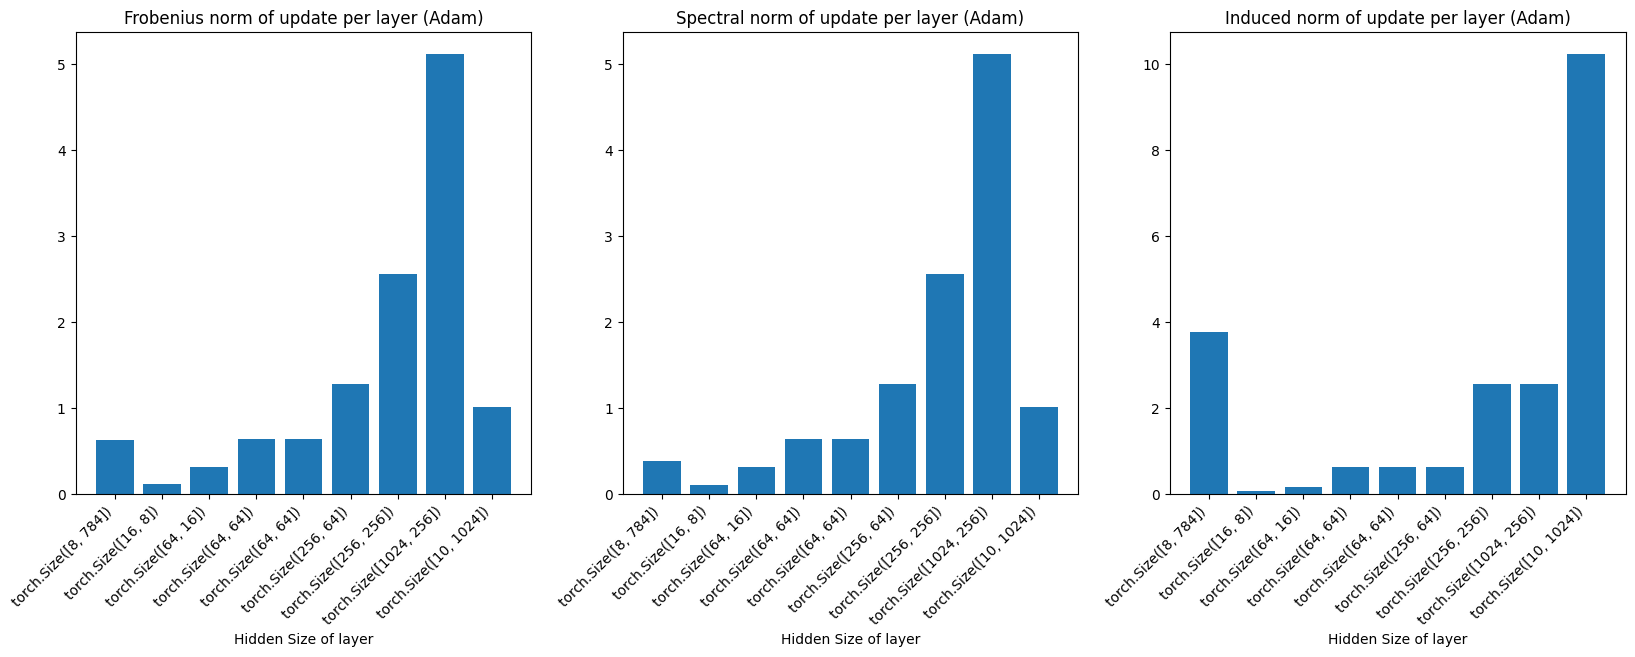

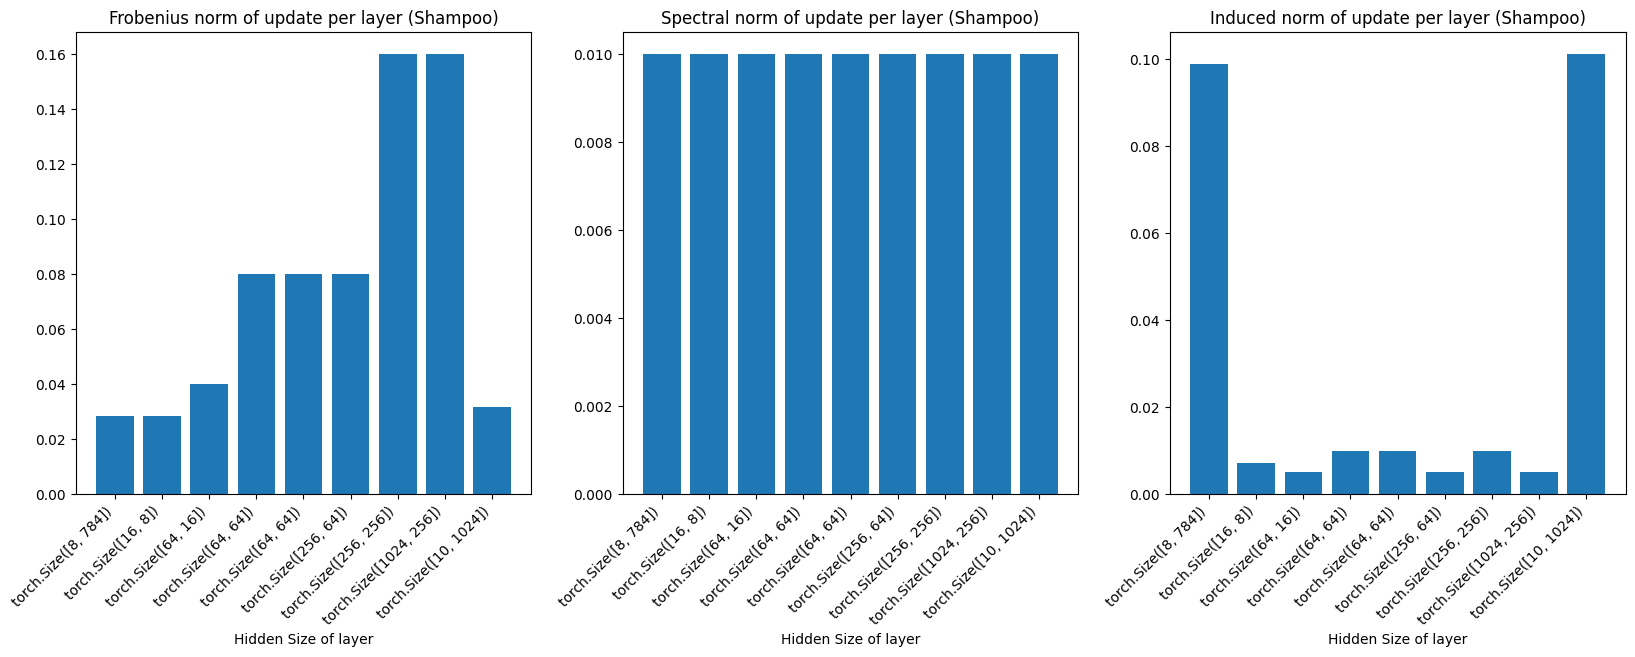

In [58]:
train_one_step_matrices(optimizer=SimpleAdam)
train_one_step_matrices(optimizer=SimpleShampoo, label="Shampoo")

In [69]:
# Bonus
from torch.optim.optimizer import Optimizer
from typing import Any
class SimpleShampoo_modified(Optimizer):
    def __init__(
        self,
        params: Any,
        lr: float = 1e-1,
        b1: float = 0.9,
    ):
        defaults = dict(lr=lr, b1=b1)
        # super(SimpleShampoo, self).__init__(params, defaults)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1-group["b1"])

                ############ TODO
                if len(m.shape) == 1:
                    # bias terms: just use momentum as update
                    u = m
                else:
                    # weight matrix: do SVD
                    U, S, Vh = torch.linalg.svd(m, full_matrices=False)
                    u = U @ Vh  # drop singular values, keep orthogonal factors
                    u *= (m.shape[0]/m.shape[1])**0.5
                #############
                p.add_(u, alpha=-group['lr'])
        return None

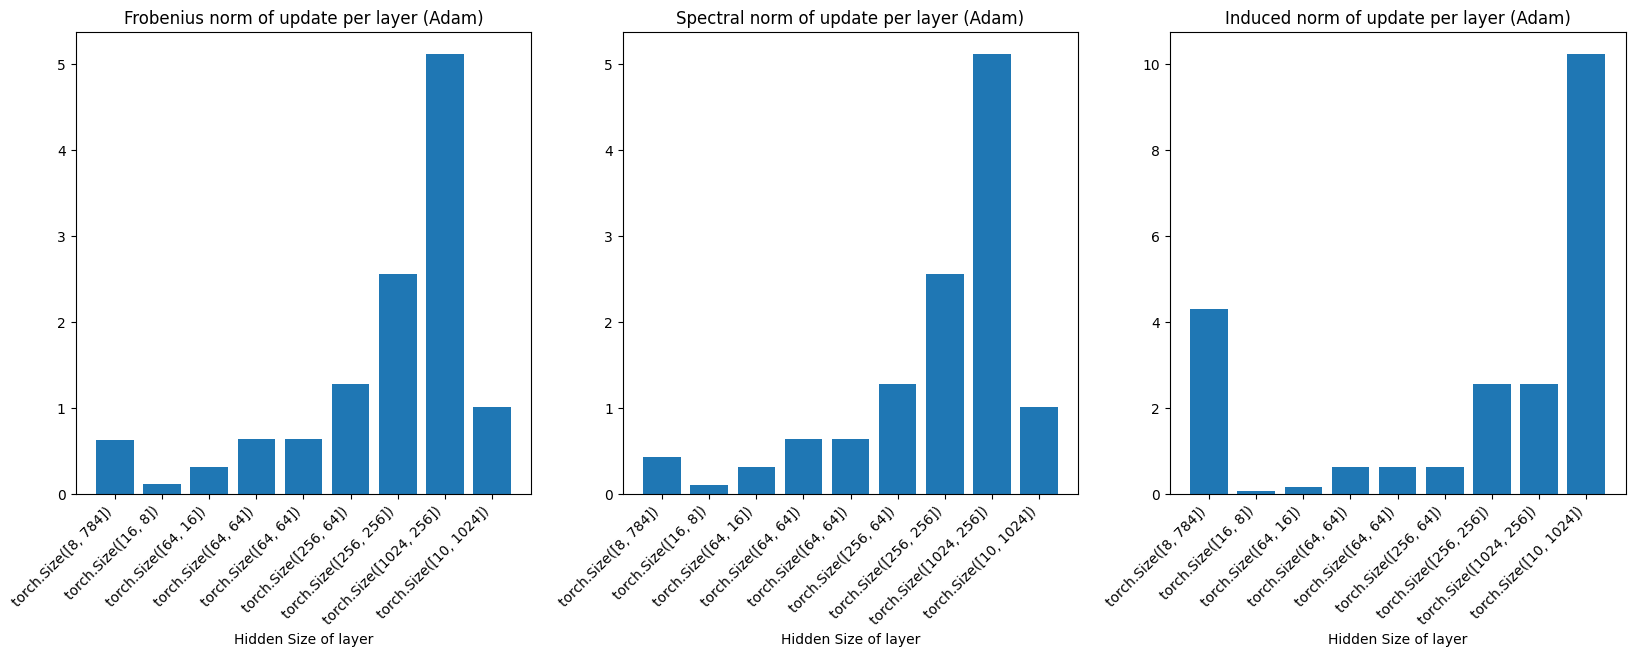

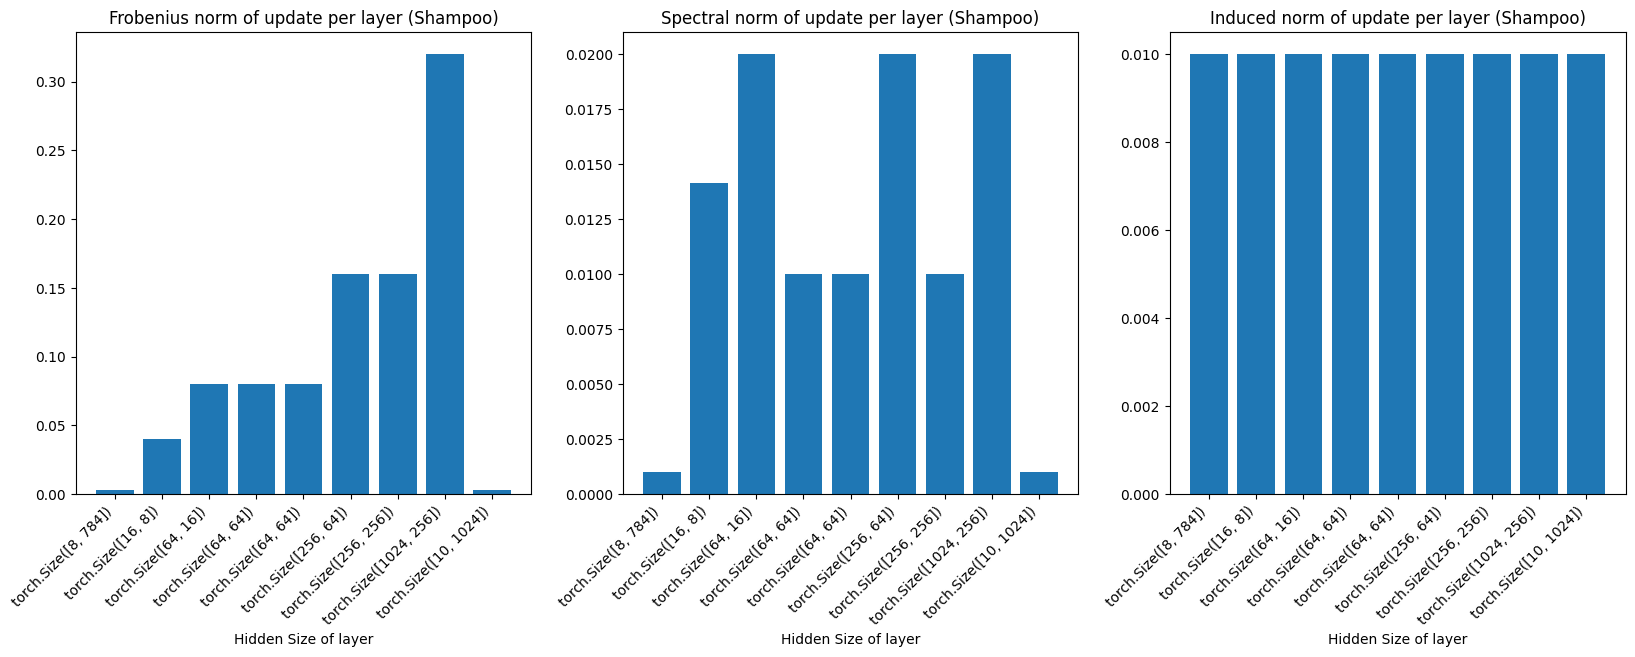

In [70]:
train_one_step_matrices(optimizer=SimpleAdam)
train_one_step_matrices(optimizer=SimpleShampoo_modified, label="Shampoo")